In [2]:
# this code is to test the musculokseletal behaviou just based on osim activation/excitation
# the model's data is in xlsx look for osim_muscles.xlsx 
# if activation specified 'yes', we can use a particular activation profile to target this particular muscle only
# simularly lock joints, if 'yes', it is 'locked'

#contributors: madhav

#######################################
#helper fucntions
####################################
import numpy as np
import sys,math
import json, socket
#import opsim
import opensim as osim
import pandas as pd
from matplotlib import pyplot as plt
import os

mypath = os.getcwd()
print mypath

get_input_osim_musc_file_path =  mypath + "/osim_muscles.xlsx"


#load osim muscles and their default control here
load_osim_musc = pd.read_excel(get_input_osim_musc_file_path,sheetname='osim_muscles')
#load osim joints and their status here 
load_osim_joints = pd.read_excel(get_input_osim_musc_file_path,sheetname='osim_joints')

#load_osim_neuroid map 
#neuroid_osim map
#load_neuroid_osim_map = pd.read_excel("/home/madhav/Documents/NEUROID_testing/sim5/moto_osim_musc_map.xlsx",sheetname="moto_osim_musc_map")
#load_osim_drg_map = pd.read_excel(get_osim_musc_drg_map_file(),sheetname="osim_musc_drg_map")

#load osim model
cwd = os.getcwd()
model_name = cwd + "/opensim/ArnoldHamner_LegsTorsoArms_v2.1.osim"
model = osim.Model(model_name)

#set gravity to zero
gravity_vec = osim.Vec3(0,0,0)
model.setGravity(gravity_vec)

model.setUseVisualizer(True)
joints = model.getJointSet()
muscles= model.getMuscles()

#create a prescribed controller 
brain = osim.PrescribedController()

# Add the controller to the model
model.addController(brain)
muscles_list = []
for j in range(model.getMuscles().getSize()):    
            func = osim.Constant(0.0)
            muscles_list.append(model.getMuscles().get(j).getName())
            #print("muscle index: {} and muscle name :{}".format(j,model.getMuscles().get(j).getName()))
            brain.addActuator(model.getMuscles().get(j))
            #set muscle activations to zero in the bigenning
            brain.prescribeControlForActuator(j, func)


def write_afferent_to_neuroid(c,firing_to_neuroid_dict):
    jsmsg = firing_to_neuroid_dict
    c.send(json.dumps(jsmsg))
    c.close()

#function to extract activations dict received from neuroid into a list 
def extract_muscle_ids(muscle_activations):
    muscles_ids = []
    for each in muscle_activations: 
        muscles_ids.append(each["id"])
    return muscles_ids

#function to extract the name strings of the osim muscles from the ids extracted from the activations_dict
def extract_muscles_names(osim_muscles,muscles_ids):    
    neuroid_muscles_list = []
    for each in muscles_ids: 
        neuroid_muscles_list.append(osim_muscles.get(each).getName())
    return neuroid_muscles_list

#pass the list of the joint_indices that need to be locked
def lock_joints(model,joint_indices_list):
    joints = model.getJointSet()
    for joint_index in joint_indices_list:
        joint = joints.get(joint_index)
        for t in range(joint.numCoordinates()):
            joint.get_coordinates(t).setLocked(state,True) 
        print joints.get(joint_index).getName(),"is locked"

#pass the list of  muscle activation received from neuroid in the following  
#format [{'id': osim_musle_id, 'act' : muscle_activation_value_from_neuroid}, .......]
#fucntion to set the activation value directly by calling the prescribeControlForActuator module of the brain <brain is PrescribedController>
def set_activation_value1(muscl_activation):
    for each in muscl_activation:
        muscle_id = each['id']
        muscle_act = float(each['act'])
        func2 = osim.Constant(muscle_act)
        print muscle_act, muscle_id
        brain.prescribeControlForActuator(muscle_id,func2)

#set activation values in loop <testing purposes only>
def set_activation_value2(muscl_activation,j):
    muscle_id_list = []
    muscle_act_list = []
    for each in muscl_activation:
        muscle_id_list.append(each['id'])
        muscle_act_list.append(float(each['act'][j]))
                               
    for i in range(len(muscle_id_list)):
             func2 = osim.Constant(muscle_act_list[i])
             brain.prescribeControlForActuator(muscle_id_list[i],func2)
        
    for muscle_id in range(model.getMuscles().getSize()):
            if muscle_id not in muscle_id_list:
                func = osim.Constant(0.0)
                #print("muscle index: {} and muscle name :{}".format(j,model.getMuscles().get(j).getName()))                        
                #brain.addActuator(model.getMuscles().get(muscle_id))
                brain.prescribeControlForActuator(muscle_id, func)

#empty dataframes to store values of muscle's previous lengths, velocity, force, 
#all dataframes are of shape 1xlen(osim.model.muscles)
#optimum length(optimal_fibre_length) is constant param of a particular muscles 
#each muscles optimum lenghts initialized as zero dataframe
muscles_opti_l = pd.DataFrame(0,index=[0],columns = muscles_list)

#fill the above dataframe with the optimum lenghts of each muscle
for i in range(muscles.getSize()):
    mus_name = muscles.get(i).getName()
    muscles_opti_l.loc[:,mus_name] = muscles.get(i).get_optimal_fiber_length()
    
#load joints into joint dataframe
#<need to be done for later work>

#empty dataframes to store values of muscles previous lengths, velocity, force during simulation
#all dataframes are of shape 1xlen(osim.model.muscles)
muscles_prev_l = pd.DataFrame(0,index=[0],columns = muscles_list)
muscles_current_l = pd.DataFrame(0,index=[0],columns = muscles_list)
muscles_vel = pd.DataFrame(0,index=[0],columns = muscles_list)
muscles_force = pd.DataFrame(0,index=[0],columns = muscles_list)

#joiunt aggles for multiple coordinates no support
#<need to be done for later work>

#load the requested drgs, source_opensim_muscles, opensim_muscle_ids to the lists from osim_drg_map
#get_osim_muscle_list = load_osim_drg_map.muscle_name.unique().tolist()
#get_target_drg_list = load_osim_drg_map.target_drg.unique().tolist()
#get_osim_muscle_id_list = load_osim_drg_map.index_number.unique().tolist() #obtain this list from xlsx

# fxn to update the parameters of all muscles (irrespective of the requested muscles) in loop
#input #empty dataframes: muscles_current_l, muscles_vel, muscles_force and osim_state, muscles_id = list of all osim_muscle_ids
#output# updated dataframes 
def update_muscles_params(osim_state,osim_muscles,muscles_current_l,muscles_vel,muscles_force,muscles_id,iterator):
    for each in muscles_id:
        osim_muscle_name = osim_muscles.get(each).getName()
        muscles_current_l.loc[iterator,osim_muscle_name] = osim_muscles.get(each).getFiberLength(osim_state)
        muscles_vel.loc[iterator,osim_muscle_name] = osim_muscles.get(each).getFiberVelocity(osim_state)
        muscles_force.loc[iterator,osim_muscle_name] = osim_muscles.get(each).getActiveFiberForce(osim_state)
        
#input is osim-state and osim_model_muscles, and muscles_ids
#update only those muscles that are querried for via osim_drg map
#input# osim_state, osim_muscles, muscles_id = list of only requested muscles,
#<can be deprecated>
def update_muscle_params(osim_state,osim_model_muscles,muscles_id):
    #create empty dataframes for length, velocity and force
    muscle_current_l = pd.DataFrame(0,index=[0],columns = muscles_list)
    muscle_vel = pd.DataFrame(0,index=[0],columns = muscles_list)
    muscle_force = pd.DataFrame(0,index=[0],columns = muscles_list)
    for each in muscles_id:
        osim_muscle_name = osim_muscles.get(each).getName()
        muscle_current_l.loc[:,osim_muscle_name] = osim_muscles.get(each).getFiberLength(osim_state)
        muscle_vel.loc[:,osim_muscle_name] = osim_muscles.get(each).getFiberVelocity(osim_state)
        muscle_force.loc[:,osim_muscle_name] = osim_muscles.get(each).getFiberForce(osim_state) #verify this later
    return muscle_current_l, muscle_vel, muscle_force 

#following need to be called in the loop during simulation
#muscle_cur_l, muscle_vel, muscle_force = update_muscle_length(state,muscles,muscles_current_l,muscles_id)

#once the muscle parameters are parsed into dataframes use them to caluclate the afferent feed back
#muscle_prev_l = muscle_cur_l at first loop

#input muscle_prev_l_df, muscle_cur_l_df, muscle_vel_df, 
def eval_aff_feedback(muscles_opti_l,muscles_prev_l_df,muscles_current_l_df,muscles_vel_df,muscles_force_df,osim_drg_map,neuroid_musc_list,iterator):
    
    def get_del_muscle_l(muscles_prev_l_df,muscles_cur_l_df):
        del_muscles_l_df = (muscles_current_l_df - muscles_prev_l_df).abs()
        #del_muscles_l_df[del_muscles_l_df<0].multiply(-10)
        return del_muscles_l_df
    
    def normalise_muscle_param(param_df,norm_df):
        #param_df = any dataframe of any parameter 
        #norm_value_df = dataframe of any constant parameter [the legnth or sizes should match]
        normalised_df = param_df.div(norm_df)
        return normalised_df 
        
    def cal_IaAfferent(norm_muscle_vel,norm_muscle_l,alpha_gamma_co=0.1,power_fac=0.5,default_pps=10):
        Ia_firing = 65*(norm_muscle_vel)**power_fac + 200*(norm_muscle_l) - 8 * alpha_gamma_co + default_pps
        return Ia_firing
    
    def cal_IIAfferent(norm_muscle_l,default_pps=10):
        II_firing = 100*norm_muscle_l+default_pps
        return II_firing
    
    def cal_IbAfferent(muscle_force):
        Ib_firing = 10**(0.4939*math.log10(muscle_force)+2.3154)
        return Ib_firing
    
    
    #function finds and evaluates affernt firing rate when a drg_neuron and all muscle_params are given
    def find_cal_aff_firing(target_drg_neuron,source_muscle,norm_muscles_l_df,norm_muscles_v_df,muscles_force_df,):
        
        print target_drg_neuron
        #Pool the tags into a list
        tag_list = target_drg_neuron.split("_") 
        #muscle_length and muscle_vel for a particular muscle
        
        norm_muscle_vel = np.fabs(norm_muscles_v_df.loc[0,source_muscle])
        norm_muscle_l = np.fabs(norm_muscles_l_df.loc[0,source_muscle])
        muscle_force = muscles_force_df.loc[0,source_muscle]
        

            #identify any of the following in the tag and calculate the appropriate firing rates accordingly
        if (target_drg_neuron.find("Ia") != -1) :
            #aff_func.append(cal_IaAffrent)
            firing = cal_IaAfferent(norm_muscle_vel,norm_muscle_l,alpha_gamma_co=0.1,power_fac=0.5,default_pps=10)
            print 'yes_Ia_fired'
            
        if (target_drg_neuron.find("II") != -1) :
            #aff_func.append(cal_IIAfferent)
            firing = cal_IIAfferent(norm_muscle_vel,default_pps=10)
            print 'yes_II_fired'
            
        if (target_drg_neuron.find("Ib") != -1) :
            firing = cal_IbAfferent(muscle_force)
            print 'yes_Ib_fired'
        return firing
    
     
    #function to skim the paramater dataframe using osim_muscle_list, obtain only those params of muscles that are requested
    def skim_df(muscles_param_df,neuroid_muscles_list,iterator):
        #osim_param_df can be muscles_length_df, muscle_velocity_df, muscle_anyparam_df
        skimmed_df = muscles_param_df.loc[[iterator],neuroid_muscles_list].reset_index(drop=True)
        return skimmed_df
    
    #step1 
    #skim the dataframes to the the the current muscles's params 
    muscle_current_l_df = skim_df(muscles_current_l_df,neuroid_muscles_list,iterator).abs()
    muscle_prev_l_df = skim_df(muscles_prev_l_df,neuroid_muscles_list,iterator).abs()
    muscle_vel_df = skim_df(muscles_vel_df,neuroid_muscles_list,iterator).abs()
    muscle_force_df = skim_df(muscles_force_df,neuroid_muscles_list,iterator)
    muscle_opti_l = muscles_opti_l.loc[[0],neuroid_muscles_list]
    
    #get the change in length for all muscles into a dataframe
    del_muscle_l_df = get_del_muscle_l(muscle_prev_l_df,muscle_current_l_df)
    
    #normalize the lengths and velocities
    norm_muscle_l_df = normalise_muscle_param(del_muscle_l_df,muscle_opti_l)
    norm_muscle_vel_df = normalise_muscle_param(muscles_vel,muscle_opti_l)
    
    #step2 
    #create a aff_firing_df with empty 'firing_in_Hz' column and that is eventually will be sent to neuroid 
    #extract only those drg with proprioception 'on' cases
    firing_to_neuroid = osim_drg_map.loc[osim_drg_map['proprioception']=='on']
    firing_to_neuroid = firing_to_neuroid.loc[:,['target_drg','muscle_name','firing_in_Hz']]
    
    #step3 fill the firings in the above dataframe's firing column using the afferent firing formulas
    #very cumburesome step and has to clculate firing values of all the drg_neurons 
    if firing_to_neuroid.shape[0] != 0:
        for each in range(firing_to_neuroid.shape[0]):
                target_drg_neuron = firing_to_neuroid.iloc[each,:]['target_drg']
                source_muscle = firing_to_neuroid.iloc[each,:]['muscle_name']
                firing = find_cal_aff_firing(target_drg_neuron,source_muscle,del_muscle_l_df,norm_muscle_l_df,muscle_force_df)
                #print firing
                firing_to_neuroid.loc[each,'firing_in_Hz'] = firing  
                
    #return firing to neuroid dataframe 
    return firing_to_neuroid 

# def get_state_values(osim_state,state_variable,variable_id,):
#     #returns either dict of values or  
#     if state_variable == "fibre_length":
#         msucle = muscles.get(variable_id)
#         variable_val = muscle.getFiberLength(osim_state)
#         return variable_val
#     if state_variable == "joint_angle":
#         joint = joints.get(variable_id) 
#         if joint.numCoordinates() == 1:
#             variable_val = joint.getCoordinate().getValue(state)
#             return variable_val
#         else:
#             #store multi coordinate values
#             variable_dict = {}
#             for j in range(jnt.numCoordinates()):
#                 variable_val["val"+str(j)]=joint.get_coordinates(j).getValues(state)               
                
#             return variable_dict

def update_joint_vals(osim_state,joint_name,joint_id,joint_angles_dict):
    joint = joints.get(joint_id) 
    if joint.numCoordinates() == 1:
        joint_val = joint.getCoordinate().getValue(state)
        joint_angles_dict[joint_name].append(joint_val)
    else:
        #store multi coordinate values
        #variable_dict = {}
        for j in range(joint.numCoordinates()):
            joint_val = joint.get_coordinates(j).getValue(state)
            jnt_name = joint_name + "_" + str(j)
            joint_angles_dict[jnt_name].append(joint_val)
            #variable_val[joint_name+str(j)]=joint.get_coordinates(j).getValues(state)    

/home/neurowiz/Desktop/osim_muscle_act_analysis


/home/neurowiz/anaconda2/lib/python2.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


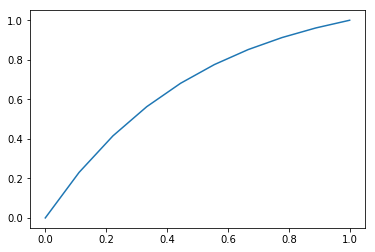

In [3]:
#design your own activation values and study the musculoskeletal behaviour
#activation for muscle simulation
c = -2
fx1 = lambda x: (math.exp(c*x)-1)/(math.exp(c)-1) #exponential 
fx2 = lambda x: (1/(1+math.exp(-x))) #logistic function
fx3 = lambda x: x # constant function 
fx1 = np.vectorize(fx1); fx2 = np.vectorize(fx2); fx3 = np.vectorize(fx3)
xvals = np.linspace(0,1,10) #100 values ranging from 0-1 
#xvals = np.linspace(-10,10,100) #100 values ranging from -10 to 10
yvals = fx1(xvals)
plt.plot(xvals,yvals)

In [4]:
#pool the desired muscles to activate
muscle_dat = load_osim_musc[load_osim_musc["act"]=='yes']
muscle_dat['index_number'].tolist()

[2, 3, 4, 24, 25, 27, 32, 34, 35, 42, 43, 44]

In [124]:
default_act = [{'id':12,'act':0.1}]

In [5]:
#pool the desired muscles to activate
load_osim_musc[load_osim_musc["act"]=='yes']

#function to assign the muscle activation and index_number # only one muscle
# def synth_act(muscle_dat,function_type,t,dt,count):
#     muscle_idx = muscle_dat['index_number'].tolist()[0]
#     xvals = np.linspace(0,1,t/dt) #values ranging from 0-1
#     act_val = round(abs(function_type(xvals[count])),3)
#     act_dict = [{'id' : muscle_idx,
#                'act': act_val}]
#     return act_dict

#function to assign the muscle activation and index_number # only one muscle
def synth_act(muscle_dat,function_type,t,dt,count):
    act_dict = []
    for each in muscle_dat['index_number'].tolist():
        xvals = np.linspace(0,1,t/dt) #values ranging from 0-1
        act_val = round(abs(function_type(xvals[count])),3)
        act_dict.append({'id' : each,
                   'act': act_val})
    return act_dict

In [5]:
float(abs((synth_act(muscle_dat,fx1,200,0.025,26)[0]['act'])))

/home/neurowiz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  import sys


0.023

In [69]:
#########################################
#initiialization and siulation code
#main simulation code
#########################################
state = model.initSystem()
model.equilibrateMuscles(state)

#obtain indeces of the joints to be locked from the user 
joint_indices_list = load_osim_joints.loc[load_osim_joints['joint_lock_state'] =='yes']['index_number'].tolist()

#joint names to track
joint_names_list = load_osim_joints.loc[load_osim_joints['joint_lock_state'] =='no']['joint_name'].tolist()

#extended joint angles dict
#empty lists for each type of joints
joint_angles_dict = {}
for each in joint_names_list:
    num_coord = load_osim_joints.loc[load_osim_joints['joint_name'] == each]['num_coordinates'].tolist()[0]
    #print num_coord
    if num_coord > 1:
        for i in range(num_coord):
            joint_angle_name = each + "_" + str(i)
            joint_angles_dict[joint_angle_name] = []
    if num_coord == 1:
        joint_angles_dict[each] = []

#print joint_names_list
#print joint_indices_list
#print load_osim_joints.loc[load_osim_joints['joint_lock_state'] =='no']['index_number'].tolist()

#lock joints 
print joint_indices_list
lock_joints(model,joint_indices_list)

#add model to manager
manager = osim.Manager(model)
manager.setIntegratorMethod(osim.Manager.IntegratorMethod_Verlet)

#initialize the state
manager.initialize(state)

#set initial time 
state.setTime(0)

#total time of simulation= obntain from the setup.json
total_time_ms = 200.0 #in milli seconds
total_time_s = total_time_ms/1000.0 #time in seconds
print total_time_ms
time_iterator = 0.0
#main simulation loop
#stepsize = h.dt/1000.0 

stepsize = 1/1000.0 #step in seconds
#n_socket = create_neuroid_socket()
firings_to_df = pd.DataFrame()
time_array = np.linspace(0,total_time_s,total_time_s/stepsize)
#print time_array[2000]
#firings = []
j=0 #iterator
# Wait for client connection in a loop

#empty dataframes to track variables
joint_angles = pd.DataFrame(0,index = time_array, columns = joint_names_list)
joint_angles = joint_angles.astype(float)
#print joint_angles.loc[time_array[1999],'ankle_l']
#(time_iterator<total_time_s)

while (time_iterator<total_time_s):
    print j, time_iterator, total_time_s, type(time_iterator), type(total_time_s)
    if j == int(total_time_s/stepsize):
        print "yes"
        break
    else: print "no...."
    

    #Actuate the muscles in OpenSim model and advance the simulation
    if j != 0:
        activations_dict = synth_act(muscle_dat,fx1,total_time_s,stepsize,j)
        #activations_dict = default_act
        print activations_dict
        set_activation_value1(activations_dict)
        muscles_ids = extract_muscle_ids(activations_dict)
    
    #set time step
    state.setTime(j*stepsize)
    
    state.autoUpdateDiscreteVariables()
    
    #integrate
    state = manager.integrate(stepsize*(j+1))
 
    #assign the osim_drg_map
    #osim_drg_map = load_osim_drg_map.copy() 
    
    #extract muscle_ids and muslce names from the muscle_activation dict sent from the neuroid
    #if activations_dict == True:
        #muscles_ids = extract_muscle_ids(activations_dict)
    #neuroid_muscles_list = extract_muscles_names(muscles,muscles_ids)
    
    #write osim variables to the dataframe 
#     for each in joint_names_list:
#             joint_var_id =  load_osim_joints.loc[load_osim_joints['joint_name'] == each]['index_number'].tolist()[0]
#             print "cord Id", joint_var_id
#             if joint_var_id == 0:
#                 pass
#             else:
#                 update_joint_val(state,each,joint_var_id,joint_angles_dict)
#                 #joint_angles.at[time_array[j],each] = get_state_values(state,"joint_angle",joint_var_id[0])
#                 #print joint_angles.loc[time_array[j],each]
    
    
    if j != 0: #and j % 2 ==0:
        print j, "update params"
        update_muscles_params(state,muscles,muscles_current_l,muscles_vel,muscles_force,muscles_ids,j)
        
        for each in joint_names_list:
            joint_var_id =  load_osim_joints.loc[load_osim_joints['joint_name'] == each]['index_number'].tolist()[0]
            print "cord Id", joint_var_id
            if joint_var_id == 0:
                pass
            else:
                update_joint_vals(state,each,joint_var_id,joint_angles_dict)

    ##update the muscles parameters at each time step
    #update_muscles_params(state,muscles,muscles_current_l,muscles_vel,muscles_force,muscles_ids,j)
    

    #if j != 0:
        ##calculate the afferent feedback  
        #aff_feedback = eval_aff_feedback(muscles_opti_l,muscles_prev_l,muscles_current_l,muscles_vel,muscles_force,osim_drg_map,neuroid_muscles_list,j)
        ##firings.append(firin_neuroid.to_dict(orient='dict'))
        #firings_to_df = firings.append(aff_feedback)
        #firings_to_neuroid = aff_feedback.to_dict(orient='dict') 

    ##send the afferent feedback to neuroid
    ##handle all proprioception "off" cases where the firings_to_neuroid will render an empty dataframe 
    ##write_afferent_to_neuroid(conn,firings_to_neuroid)
    ##eact = eact+0.01
    
    ##update muscles_prev dataframe
    #muscles_prev_l = muscles_current_l
    j = j+1
    time_iterator = time_iterator + stepsize
    

#push the osim variables to the designated folders     
 
print "while_loop finished" 
#joint_angles.plot.line()
#plt.show()

#write the firing dataframe to a xlsx sheet
#firing

[6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
patellofemoral_r is locked
hip_l is locked
femur_coord_l is locked
walker_knee_l is locked
tibia_coord_l is locked
femoral_shaft_l is locked
patellofemoral_l is locked
ankle_l is locked
subtalar_l is locked
mtp_l is locked
back is locked
acromial_r is locked
elbow_r is locked
radioulnar_r is locked
radius_hand_r is locked
acromial_l is locked
elbow_l is locked
radioulnar_l is locked
radius_hand_l is locked
200.0
0 0.0 0.2 <type 'float'> <type 'float'>
no....
1 0.001 0.2 <type 'float'> <type 'float'>
no....


/home/neurowiz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


[{'id': 2, 'act': 0.012}, {'id': 3, 'act': 0.012}, {'id': 4, 'act': 0.012}, {'id': 24, 'act': 0.012}, {'id': 25, 'act': 0.012}, {'id': 27, 'act': 0.012}, {'id': 32, 'act': 0.012}, {'id': 34, 'act': 0.012}, {'id': 35, 'act': 0.012}, {'id': 42, 'act': 0.012}, {'id': 43, 'act': 0.012}, {'id': 44, 'act': 0.012}]
0.012 2
0.012 3
0.012 4
0.012 24
0.012 25
0.012 27
0.012 32
0.012 34
0.012 35
0.012 42
0.012 43
0.012 44
1 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
2 0.002 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.023}, {'id': 3, 'act': 0.023}, {'id': 4, 'act': 0.023}, {'id': 24, 'act': 0.023}, {'id': 25, 'act': 0.023}, {'id': 27, 'act': 0.023}, {'id': 32, 'act': 0.023}, {'id': 34, 'act': 0.023}, {'id': 35, 'act': 0.023}, {'id': 42, 'act': 0.023}, {'id': 43, 'act': 0.023}, {'id': 44, 'act': 0.023}]
0.023 2
0.023 3
0.023 4
0.023 24
0.023 25
0.023 27
0.023 32
0.023 34
0.023 35
0.023 42
0.023 43
0.023 44
2 update params

cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
16 0.016 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.172}, {'id': 3, 'act': 0.172}, {'id': 4, 'act': 0.172}, {'id': 24, 'act': 0.172}, {'id': 25, 'act': 0.172}, {'id': 27, 'act': 0.172}, {'id': 32, 'act': 0.172}, {'id': 34, 'act': 0.172}, {'id': 35, 'act': 0.172}, {'id': 42, 'act': 0.172}, {'id': 43, 'act': 0.172}, {'id': 44, 'act': 0.172}]
0.172 2
0.172 3
0.172 4
0.172 24
0.172 25
0.172 27
0.172 32
0.172 34
0.172 35
0.172 42
0.172 43
0.172 44
16 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
17 0.017 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.182}, {'id': 3, 'act': 0.182}, {'id': 4, 'act': 0.182}, {'id': 24, 'act': 0.182}, {'id': 25, 'act': 0.182}, {'id': 27, 'act': 0.182}, {'id': 32, 'act': 0.182}, {'id': 34, 'act': 0.182}, {'id': 35, 'act': 0.182}, {'id': 42, 'act': 0.182}, {'id': 43, 'act': 0.182}, {'id

cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
31 0.031 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.31}, {'id': 3, 'act': 0.31}, {'id': 4, 'act': 0.31}, {'id': 24, 'act': 0.31}, {'id': 25, 'act': 0.31}, {'id': 27, 'act': 0.31}, {'id': 32, 'act': 0.31}, {'id': 34, 'act': 0.31}, {'id': 35, 'act': 0.31}, {'id': 42, 'act': 0.31}, {'id': 43, 'act': 0.31}, {'id': 44, 'act': 0.31}]
0.31 2
0.31 3
0.31 4
0.31 24
0.31 25
0.31 27
0.31 32
0.31 34
0.31 35
0.31 42
0.31 43
0.31 44
31 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
32 0.032 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.318}, {'id': 3, 'act': 0.318}, {'id': 4, 'act': 0.318}, {'id': 24, 'act': 0.318}, {'id': 25, 'act': 0.318}, {'id': 27, 'act': 0.318}, {'id': 32, 'act': 0.318}, {'id': 34, 'act': 0.318}, {'id': 35, 'act': 0.318}, {'id': 42, 'act': 0.318}, {'id': 43, 'act': 0.318}, {'id': 44, 'act': 0.318}]
0.

cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
46 0.046 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.428}, {'id': 3, 'act': 0.428}, {'id': 4, 'act': 0.428}, {'id': 24, 'act': 0.428}, {'id': 25, 'act': 0.428}, {'id': 27, 'act': 0.428}, {'id': 32, 'act': 0.428}, {'id': 34, 'act': 0.428}, {'id': 35, 'act': 0.428}, {'id': 42, 'act': 0.428}, {'id': 43, 'act': 0.428}, {'id': 44, 'act': 0.428}]
0.428 2
0.428 3
0.428 4
0.428 24
0.428 25
0.428 27
0.428 32
0.428 34
0.428 35
0.428 42
0.428 43
0.428 44
46 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
47 0.047 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.435}, {'id': 3, 'act': 0.435}, {'id': 4, 'act': 0.435}, {'id': 24, 'act': 0.435}, {'id': 25, 'act': 0.435}, {'id': 27, 'act': 0.435}, {'id': 32, 'act': 0.435}, {'id': 34, 'act': 0.435}, {'id': 35, 'act': 0.435}, {'id': 42, 'act': 0.435}, {'id': 43, 'act': 0.435}, {'id': 44, 'act': 0.435}]
0.435 2
0.435 3
0.

cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
61 0.061 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.53}, {'id': 3, 'act': 0.53}, {'id': 4, 'act': 0.53}, {'id': 24, 'act': 0.53}, {'id': 25, 'act': 0.53}, {'id': 27, 'act': 0.53}, {'id': 32, 'act': 0.53}, {'id': 34, 'act': 0.53}, {'id': 35, 'act': 0.53}, {'id': 42, 'act': 0.53}, {'id': 43, 'act': 0.53}, {'id': 44, 'act': 0.53}]
0.53 2
0.53 3
0.53 4
0.53 24
0.53 25
0.53 27
0.53 32
0.53 34
0.53 35
0.53 42
0.53 43
0.53 44
61 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
62 0.062 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.536}, {'id': 3, 'act': 0.536}, {'id': 4, 'act': 0.536}, {'id': 24, 'act': 0.536}, {'id': 25, 'act': 0.536}, {'id': 27, 'act': 0.536}, {'id': 32, 'act': 0.536}, {'id': 34, 'act': 0.536}, {'id': 35, 'act': 0.536}, {'id': 42, 'act': 0.536}, {'id': 43, 'act': 0.536}, {'id': 44, 'act': 0.536}]
0.

cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
76 0.076 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.618}, {'id': 3, 'act': 0.618}, {'id': 4, 'act': 0.618}, {'id': 24, 'act': 0.618}, {'id': 25, 'act': 0.618}, {'id': 27, 'act': 0.618}, {'id': 32, 'act': 0.618}, {'id': 34, 'act': 0.618}, {'id': 35, 'act': 0.618}, {'id': 42, 'act': 0.618}, {'id': 43, 'act': 0.618}, {'id': 44, 'act': 0.618}]
0.618 2
0.618 3
0.618 4
0.618 24
0.618 25
0.618 27
0.618 32
0.618 34
0.618 35
0.618 42
0.618 43
0.618 44
76 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
77 0.077 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.623}, {'id': 3, 'act': 0.623}, {'id': 4, 'act': 0.623}, {'id': 24, 'act': 0.623}, {'id': 25, 'act': 0.623}, {'id': 27, 'act': 0.623}, {'id': 32, 'act': 0.623}, {'id': 34, 'act': 0.623}, {'id': 35, 'act': 0.623}, {'id': 42, 'act': 0.623}, {'id': 43, 'act': 0.623}, {'id

cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
92 0.092 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.698}, {'id': 3, 'act': 0.698}, {'id': 4, 'act': 0.698}, {'id': 24, 'act': 0.698}, {'id': 25, 'act': 0.698}, {'id': 27, 'act': 0.698}, {'id': 32, 'act': 0.698}, {'id': 34, 'act': 0.698}, {'id': 35, 'act': 0.698}, {'id': 42, 'act': 0.698}, {'id': 43, 'act': 0.698}, {'id': 44, 'act': 0.698}]
0.698 2
0.698 3
0.698 4
0.698 24
0.698 25
0.698 27
0.698 32
0.698 34
0.698 35
0.698 42
0.698 43
0.698 44
92 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
93 0.093 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.702}, {'id': 3, 'act': 0.702}, {'id': 4, 'act': 0.702}, {'id': 24, 'act': 0.702}, {'id': 25, 'act': 0.702}, {'id': 27, 'act': 0.702}, {'id': 32, 'act': 0.702}, {'id': 34, 'act': 0.702}, {'id': 35, 'act': 0.702}, {'id': 42, 'act': 0.702}, {'id': 43, 'act': 0.702}, {'id

cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
107 0.107 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.762}, {'id': 3, 'act': 0.762}, {'id': 4, 'act': 0.762}, {'id': 24, 'act': 0.762}, {'id': 25, 'act': 0.762}, {'id': 27, 'act': 0.762}, {'id': 32, 'act': 0.762}, {'id': 34, 'act': 0.762}, {'id': 35, 'act': 0.762}, {'id': 42, 'act': 0.762}, {'id': 43, 'act': 0.762}, {'id': 44, 'act': 0.762}]
0.762 2
0.762 3
0.762 4
0.762 24
0.762 25
0.762 27
0.762 32
0.762 34
0.762 35
0.762 42
0.762 43
0.762 44
107 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
108 0.108 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.766}, {'id': 3, 'act': 0.766}, {'id': 4, 'act': 0.766}, {'id': 24, 'act': 0.766}, {'id': 25, 'act': 0.766}, {'id': 27, 'act': 0.766}, {'id': 32, 'act': 0.766}, {'id': 34, 'act': 0.766}, {'id': 35, 'act': 0.766}, {'id': 42, 'act': 0.766}, {'id': 43, 'act': 0.766}, {

0.814 3
0.814 4
0.814 24
0.814 25
0.814 27
0.814 32
0.814 34
0.814 35
0.814 42
0.814 43
0.814 44
121 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
122 0.122 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.817}, {'id': 3, 'act': 0.817}, {'id': 4, 'act': 0.817}, {'id': 24, 'act': 0.817}, {'id': 25, 'act': 0.817}, {'id': 27, 'act': 0.817}, {'id': 32, 'act': 0.817}, {'id': 34, 'act': 0.817}, {'id': 35, 'act': 0.817}, {'id': 42, 'act': 0.817}, {'id': 43, 'act': 0.817}, {'id': 44, 'act': 0.817}]
0.817 2
0.817 3
0.817 4
0.817 24
0.817 25
0.817 27
0.817 32
0.817 34
0.817 35
0.817 42
0.817 43
0.817 44
122 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
123 0.123 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.821}, {'id': 3, 'act': 0.821}, {'id': 4, 'act': 0.821}, {'id': 24, 'act': 0.821}, {'id': 25, 'act': 0.821}, {'id': 27, 'act': 0.821}, {'id': 32, 'act'

cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
138 0.138 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.868}, {'id': 3, 'act': 0.868}, {'id': 4, 'act': 0.868}, {'id': 24, 'act': 0.868}, {'id': 25, 'act': 0.868}, {'id': 27, 'act': 0.868}, {'id': 32, 'act': 0.868}, {'id': 34, 'act': 0.868}, {'id': 35, 'act': 0.868}, {'id': 42, 'act': 0.868}, {'id': 43, 'act': 0.868}, {'id': 44, 'act': 0.868}]
0.868 2
0.868 3
0.868 4
0.868 24
0.868 25
0.868 27
0.868 32
0.868 34
0.868 35
0.868 42
0.868 43
0.868 44
138 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
139 0.139 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.87}, {'id': 3, 'act': 0.87}, {'id': 4, 'act': 0.87}, {'id': 24, 'act': 0.87}, {'id': 25, 'act': 0.87}, {'id': 27, 'act': 0.87}, {'id': 32, 'act': 0.87}, {'id': 34, 'act': 0.87}, {'id': 35, 'act': 0.87}, {'id': 42, 'act': 0.87}, {'id': 43, 'act': 0.87}, {'id': 44, '

152 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
153 0.153 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.908}, {'id': 3, 'act': 0.908}, {'id': 4, 'act': 0.908}, {'id': 24, 'act': 0.908}, {'id': 25, 'act': 0.908}, {'id': 27, 'act': 0.908}, {'id': 32, 'act': 0.908}, {'id': 34, 'act': 0.908}, {'id': 35, 'act': 0.908}, {'id': 42, 'act': 0.908}, {'id': 43, 'act': 0.908}, {'id': 44, 'act': 0.908}]
0.908 2
0.908 3
0.908 4
0.908 24
0.908 25
0.908 27
0.908 32
0.908 34
0.908 35
0.908 42
0.908 43
0.908 44
153 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
154 0.154 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.91}, {'id': 3, 'act': 0.91}, {'id': 4, 'act': 0.91}, {'id': 24, 'act': 0.91}, {'id': 25, 'act': 0.91}, {'id': 27, 'act': 0.91}, {'id': 32, 'act': 0.91}, {'id': 34, 'act': 0.91}, {'id': 35, 'act': 0.91}, {'id': 42, 'act': 0.91}, {'id': 43, 'act': 0

cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
168 0.168 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.943}, {'id': 3, 'act': 0.943}, {'id': 4, 'act': 0.943}, {'id': 24, 'act': 0.943}, {'id': 25, 'act': 0.943}, {'id': 27, 'act': 0.943}, {'id': 32, 'act': 0.943}, {'id': 34, 'act': 0.943}, {'id': 35, 'act': 0.943}, {'id': 42, 'act': 0.943}, {'id': 43, 'act': 0.943}, {'id': 44, 'act': 0.943}]
0.943 2
0.943 3
0.943 4
0.943 24
0.943 25
0.943 27
0.943 32
0.943 34
0.943 35
0.943 42
0.943 43
0.943 44
168 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
169 0.169 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.945}, {'id': 3, 'act': 0.945}, {'id': 4, 'act': 0.945}, {'id': 24, 'act': 0.945}, {'id': 25, 'act': 0.945}, {'id': 27, 'act': 0.945}, {'id': 32, 'act': 0.945}, {'id': 34, 'act': 0.945}, {'id': 35, 'act': 0.945}, {'id': 42, 'act': 0.945}, {'id': 43, 'act': 0.945}, {

cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
185 0.185 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.976}, {'id': 3, 'act': 0.976}, {'id': 4, 'act': 0.976}, {'id': 24, 'act': 0.976}, {'id': 25, 'act': 0.976}, {'id': 27, 'act': 0.976}, {'id': 32, 'act': 0.976}, {'id': 34, 'act': 0.976}, {'id': 35, 'act': 0.976}, {'id': 42, 'act': 0.976}, {'id': 43, 'act': 0.976}, {'id': 44, 'act': 0.976}]
0.976 2
0.976 3
0.976 4
0.976 24
0.976 25
0.976 27
0.976 32
0.976 34
0.976 35
0.976 42
0.976 43
0.976 44
185 update params
cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
186 0.186 0.2 <type 'float'> <type 'float'>
no....
[{'id': 2, 'act': 0.978}, {'id': 3, 'act': 0.978}, {'id': 4, 'act': 0.978}, {'id': 24, 'act': 0.978}, {'id': 25, 'act': 0.978}, {'id': 27, 'act': 0.978}, {'id': 32, 'act': 0.978}, {'id': 34, 'act': 0.978}, {'id': 35, 'act': 0.978}, {'id': 42, 'act': 0.978}, {'id': 43, 'act': 0.978}, {

cord Id 0
cord Id 1
cord Id 2
cord Id 3
cord Id 4
cord Id 5
cord Id 7
cord Id 8
cord Id 9
while_loop finished


/home/neurowiz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


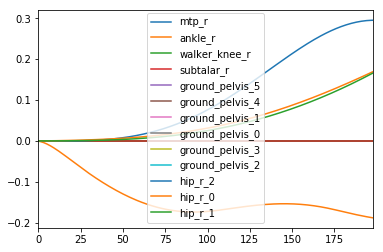

In [77]:
#joint angles plot
joint_angles_df  = pd.DataFrame.from_dict(joint_angles_dict, orient  = 'index')
joint_angles_df = joint_angles_df.T
joint_angles_df.plot.line()

In [ ]:
# variable that are tracked can be retrived here, each of these are data frames
# write these variable to xlsx or plot directly using dataframe plotting
muscles_force, muscles_vel, muscles_current_l